# What Movies Make Money in Hollywood?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> For this project, I have selected the TMDb database(some redundacy due to the acronym) to analyze movie data. 
> Particularly, I looked  at this database through the lense of a data scientist working in Hollywood who is giving insight
> to producers what traits and people are involved in some of our biggest blockbusters, as well as movies that have had a great
> return on investment(ROI). With the extensive data I have to play with, I will condense it down to look at several different
> variables, with a strong focus on variables that producers can change(they can't change their movies' votes on TMDb for
> example). Through some questions, and playing with the data, I have gained valuable insights that I can use a basis for
> future data analysis when my skillset is stronger.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

df = pd.read_csv('tmdb-movies.csv')

ModuleNotFoundError: No module named 'pandas'

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [ ]:
display(df.head())
df.info()

In [ ]:
df.describe()

In [ ]:
df.isna().sum() #see how many NaN in each category

In [ ]:
df.dtypes

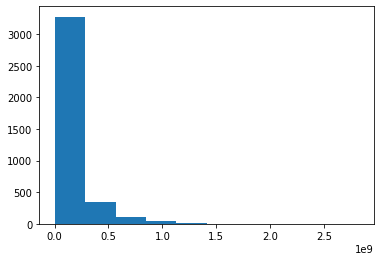

In [10]:
plt.hist(df.revenue_adj);

*A histogram of my target variable, revenue_adj. Shows the bulk of films made under $250 million(the numbers are expressed in terms of billions, which is what the 1e9 indicates at the bottom). This makes sense, as most films are not gonna be big blockbusters. However, I would be wise to explore the numbers on this lower end a little later as some films probably didn't make money directly(made-for-TV), or there could be missing/inaccurate numbers for some of them.*

### Data Cleaning

Here, I will be starting to trim down my data to make sure it is easier to utilize in my quest to find out what variables can affect the box office receipts of movies.

In [2]:
to_drop = ['homepage', 'tagline', 'keywords', 'production_companies', 'id', 'imdb_id', 'popularity', 'vote_count',
          'vote_average', 'budget', 'revenue'] 
df.drop(columns = to_drop, inplace=True)

*Getting rid of homepage, tagline, keywords, production companies as they are missing 10% or more of their data. The other columns are ones that a studio does not have control over. Also only kept my budget/revenue numbers that are adjusted for inflation to have a more precise comparison*

In [3]:
df.duplicated().sum() #dropping duplicates
df.drop_duplicates(inplace=True)

In [4]:
rows_with_na = df[df.isna().sum(axis=1) == 1]
rows_with_na.revenue_adj.value_counts()
df.dropna(inplace=True)              

*Only 125 of 10865 movies have NaN values. Confident to drop them after seeing most of them are missing revenue_adj aka my dependent variable.*

In [5]:
df.release_date = pd.to_datetime(df.release_date) #convert release_date into datetime

In [6]:
no_money = df[df['revenue_adj'] == 0].index 
df.drop(index=no_money, inplace=True) 

*Whole point of this is to understand what movies make more money. Dropping those with no revenue_adj. Could be human error,
difficulty of finding the data for foreign films, and some could be made-for-TV films. Still have 4853 rows of data*

In [7]:
df = df[df.budget_adj >= 1e5]

*Here I originally just took out films that have no budget, which of course is impossible. But after plotting later in my notebook, I notice there were "budgets" as low as a few cents. Googling up the budgets of some of the most successful low-budget independent films, made me realize $100K could be a good conservative number. Could very well be higher, but with my limited knowledge, I can just work with arbitrary numbers that at least make some sense. I still have 3805 movies in my dataset. Big difference from my initial count, but Central Limit Theorem tells me I should still be good*

In [8]:
(df.original_title.value_counts() > 1).sum()
duplicated_titles = df[df.original_title.duplicated(keep=False) == True]
((duplicated_titles.groupby('original_title')['release_year'].count()) < 2).sum()

0

*Grouping later on showed me there were some repeat titles, and made me wonder if I was premature in getting rid of the TMDb id's. But each duplicated Title also had a different year, which shows they were different movies and not a movie mistakenly written in twice. So these are coincidences(there are two 'The Avengers' movies which are completely different!), and also several remakes.*

In [9]:
df['ROI'] = df.revenue_adj/df.budget_adj #a return on investment column.

<a id='eda'></a>
## Exploratory Data Analysis



### How Have Money Revenues/ROI Changed Throughout the Years?

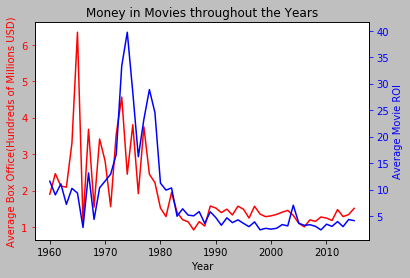

In [11]:
groupedby_year = df.groupby('release_year')
years = groupedby_year.mean().index
revenue = groupedby_year.mean().revenue_adj
roi = groupedby_year.mean().ROI

style.use('grayscale')

#plot 1. average revenue
fig, ax1 = plt.subplots()
plt.title('Money in Movies throughout the Years')
ax1.plot(years, revenue/1e8, color='r')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Box Office(Hundreds of Millions USD)', color='r')
ax1.tick_params(axis='y', colors='r' )
ax2 = ax1.twinx()

#plot 2. Average ROI
ax2.plot(years, roi, color='b')
ax2.set_ylabel('Average Movie ROI', color='b')
ax2.tick_params(axis='y', colors='b');

> **Observation:** Here, we can see ROI and revenue have a strong correlation. It makes sense as ROI is just the budget/revenue, but it would appear that Hollywood studios did a good job giving money to projects that would go on to be successful. We also see both revenue and ROI have been trending downward or plateauing since spiking in the 1970's. The spike would make sense as that was the decade of some of the biggest blockbusters that many people all over the world are familiar with, such as Jaws, Star Wars franchise, Exorcist, and Halloween(most successful independent film for a few decades). Why the change since the 70s? Would like to see if genres have something to do it it

### What genres of movies were most popular in the 1970s? how does it compared to the mix of movies since?

In [12]:
def dummy_columns(DF, col): #this function takes a Df and categorical column, and appends the original Df with dummy
                            #values of the contents of the column; then it deletes the original column.
    new_DF = DF.copy()
    dummies = new_DF[col].str.get_dummies(sep = "|")
    new_DF = pd.concat([new_DF, dummies.rename(lambda x: col + '_' + x, axis='columns') ], axis=1)
    new_DF.drop(columns = col, inplace=True)
    return new_DF

df_split_genres = dummy_columns(df, 'genres')

In [13]:
decade_70s = list(range(1970,1980))
df_1970s = df_split_genres.query('release_year in @decade_70s')
#Df of movies in 1970s, using my df where I had split the genres separately as the basis. Using this temporarily just
#to get more popular genres of that decade.

top_70s_genres = list(df_1970s.iloc[:, 10:].sum().sort_values(ascending=False)[:4].index)
#These are the 4 most popular genres of the 70s(Drama, Action, Thriller, Adventure)

actual_genre_list = list(df_split_genres.columns[10:])
#All the genres in the Df

In [15]:
number_of_70s_genres = df_split_genres.groupby('release_year').sum()[top_70s_genres].sum(axis=1)
total_genres_per_year = df_split_genres.groupby('release_year').sum()[actual_genre_list].sum(axis=1)
ratio_70s_genres = number_of_70s_genres/total_genres_per_year
#Ratio of the top 70s genres to overall genres

years = np.sort(df_split_genres.release_year.unique())
#All the years listed once in a sorted array

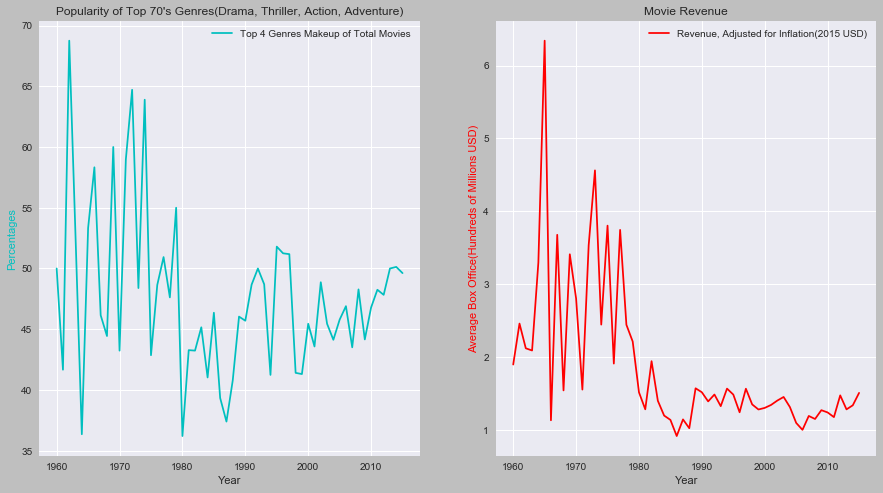

In [16]:
fig = plt.figure(figsize=(15,8))
style.use('seaborn')

#plot 1. Top 70's Genres as mix of movies made
plt.subplot(1, 2, 1)
l = 'Top 4 Genres Makeup of Total Movies'
plt.plot(years, round(ratio_70s_genres*100, 2), color='c', label=l)
plt.title('Popularity of Top 70\'s Genres(Drama, Thriller, Action, Adventure)')
plt.xlabel('Year')
plt.ylabel('Percentages', color='c')
plt.legend()

#plot 2. Movie Revenue
plt.subplot(1, 2, 2)
l = "Revenue, Adjusted for Inflation(2015 USD)"
plt.plot(years, revenue/1e8, color='r', label = l)
plt.title("Movie Revenue")
plt.xlabel('Year')
plt.ylabel('Average Box Office(Hundreds of Millions USD)', color='r')
plt.legend();

In [1]:
# Group by release year and calculate the number of movies and mean ROI
movies_per_year = df.groupby('release_year').size()  # Number of movies released per year
mean_roi_per_year = df.groupby('release_year')['ROI'].mean()  # Mean ROI per year

# Combine the two series into a DataFrame
correlation_df = pd.DataFrame({
    'Movies_Per_Year': movies_per_year,
    'Mean_ROI_Per_Year': mean_roi_per_year
})

# Calculate the correlation between the two columns
correlation = correlation_df.corr().loc['Movies_Per_Year', 'Mean_ROI_Per_Year']

# Output the correlation result
print(f"Correlation between the number of movies released each year and ROI: {correlation}")

#Quick exploration of the overall # of films produced per year
plt.hist(df.release_year); 


NameError: name 'df' is not defined

> **Observation:** The 4 most popular genres of the 1970's were Drama, Thriller, Action, Adventure(coincidently you can make the anagram DATA with those initials). The graphs do show some similar peaks and valleys in the 70's, but different paths since then. Films of the DATA genres, are slowly becoming a bigger part of movies released each year; however, the average film is bringing in less and less money when adjusted for inflation. Looks like there were definitely other factors at play for the success of the 1970's films. One possible one could be the number of films produced per year increasing ten-fold in that time! Could be a case of oversaturation in the market.

<a id='conclusions'></a>
## Final Thoughts/Conclusions

> 1. It would seem with movies breaking the billion-dollar mark at the box-office regularly that movies have never made more money. While that can be true in terms of the overall year, the average revenue from each movie is either at standstill or declining. With more data analysis(perhaps using more elements of the initial Df?), surely one can come up with ideas of what works in Hollywood. Although I didn't find a variable that does correlate with revenue, I did find some that didn't.

> 2. Was disappointed my idea to track the most popular movie genres of the 70's did not give me an answer. Well an easy answer. I am at least a littler wiser in knowing that the genre mix of movies do not have a strong effect on movie revenues. But I am sure there is something(or some things) about movies in the 70's that made them so popular.

> 3. I would be excited to explore this dataset further down the line with more data anaylst tools in my repetoire. I had thought of ways I could analyze the data further or other variables to looks at(even ones that I took out initially). Of course, this also taught me about the cyclical nature of the Data Science process. Many times through plotting or further examining the data, I would see little things I missed or suprises just waiting for me within the data. But I am not discouraged. This is just a first step.

> 4. In hindsight, there are columns I would keep for a later analysis when I have more knowledge of regression and machine learning techniques. Perhaps, I could keep TMDb score in and see how that correlates to revenue. If that has a good correlation with revenue, I could first explore questions of what features make up a movie that has a higher TMDb score. This would be great analysis as some movies have great TMDb scores, but no revenue numbers. Those movies may not have details about my target variable, but can help me explore what movies score highly. Just as I created dummy variables with genres, I could do the same to explore relationships with actors, directors, or production companies. These could be vital features, especially to see how much of a correlation(almost said effect) the actors/directors we associate with our favorite movies have with revenue.

> 5. There are some limitations. With me using just a subset of the larger Df, it can be hard to assume this could apply to the larger movie-making population. With more features to play with, I could see the intricate relationships between certain ones and how it pertains to revenue. Also, while future analysis with machine learning can make models that are pretty accurate with predicting revenue, the models would simply explain association and NOT causation. So just throwing money at certain features a model would predict to use, is not a guarantee of success.